In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import math
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict
from statistics import mean
import chess
import chess.svg
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import re
import glob
import PIL


In [8]:
# !pip install python-chess
# !pip install svglib

### Utility functions

In [20]:
def read_img(file):
    img = cv.imread(str(file))
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray_blur = cv.blur(gray, (5, 5))
    return img, gray_blur

def canny_edge(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv.Canny(img, lower, upper)
    return edges


# Hough line detection
def hough_line(edges, min_line_length=100, max_line_gap=10):
    lines = cv.HoughLines(edges, 1, np.pi / 180, 125, min_line_length, max_line_gap)
    lines = np.reshape(lines, (-1, 2))
    return lines


# Separate line into horizontal and vertical
def h_v_lines(lines):
    h_lines, v_lines = [], []
    for rho, theta in lines:
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v_lines.append([rho, theta])
        else:
            h_lines.append([rho, theta])
    return h_lines, v_lines


# Find the intersections of the lines
def line_intersections(h_lines, v_lines):
    points = []
    for r_h, t_h in h_lines:
        for r_v, t_v in v_lines:
            a = np.array([[np.cos(t_h), np.sin(t_h)], [np.cos(t_v), np.sin(t_v)]])
            b = np.array([r_h, r_v])
            inter_point = np.linalg.solve(a, b)
            points.append(inter_point)
    return np.array(points)

# Hierarchical cluster (by euclidean distance) intersection points
def cluster_points(points):
    dists = spatial.distance.pdist(points)
    single_linkage = cluster.hierarchy.single(dists)
    flat_clusters = cluster.hierarchy.fcluster(single_linkage, 15, 'distance')
    cluster_dict = defaultdict(list)
    for i in range(len(flat_clusters)):
        cluster_dict[flat_clusters[i]].append(points[i])
    cluster_values = cluster_dict.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), cluster_values)
    return sorted(list(clusters), key=lambda k: [k[1], k[0]])


# Average the y value in each row and augment original points
def augment_points(points):
    points_shape = list(np.shape(points))
    augmented_points = []
    for row in range(int(points_shape[0] / 11)):
        start = row * 11
        end = (row * 11) + 10
        rw_points = points[start:end + 1]
        rw_y = []
        rw_x = []
        for point in rw_points:
            x, y = point
            rw_y.append(y)
            rw_x.append(x)
        y_mean = mean(rw_y)
        for i in range(len(rw_x)):
            point = (rw_x[i], y_mean)
            augmented_points.append(point)
    augmented_points = sorted(augmented_points, key=lambda k: [k[1], k[0]])
    return augmented_points

def fen_to_image(fen):
    board = chess.Board(fen)
    current_board = chess.svg.board(board=board)

    output_file = open('current_board.svg', "w")
    output_file.write(current_board)
    output_file.close()

    svg = svg2rlg('current_board.svg')
    renderPM.drawToFile(svg, 'current_board.png', fmt="PNG")
    return board


In [5]:
img = cv.imread("images/2021_07_06_09_30_50_PMframe102.jpeg")
print(img.shape)

(750, 1000, 3)


True

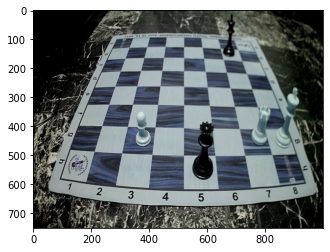

<Figure size 960x720 with 0 Axes>

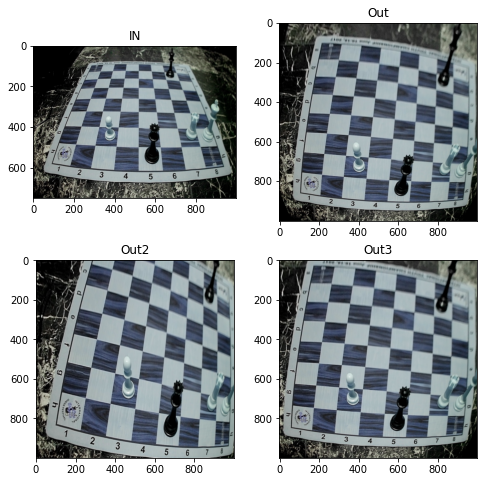

In [13]:
img = cv.imread("images/2021_07_06_09_30_50_PMframe102.jpeg")
# img = cv.imread("images/2021_07_07_09_45_57_PMframe100.jpeg")


rows,cols,ch = img.shape

pts1 = np.float32([[450,50],[100,300],[475,750],[850,250]]) #midpoints
pts2 = np.float32([[500,0],[0,500],[500,1000],[1000,500]])
pt1 = np.float32([[1000,650],[750,50],[100,200],[0,700]]) #corners
pt2 = np.float32([[1000,1000],[1000,0],[0,0],[0,1000]])
p1 = np.float32([[50,1000],[50,75],[1000,75],[1000,1000]]) #after midpoints corners
p2 = np.float32([[0,1000],[0,0],[1000,0],[1000,1000]])

M = cv.getPerspectiveTransform(pts1,pts2)
N = cv.getPerspectiveTransform(pt1,pt2)
O = cv.getPerspectiveTransform(p1,p2)

dst = cv.warpPerspective(img,M,(1000,1000))
dsst = cv.warpPerspective(img,N,(1000,1000))
# dssst = cv.warpPerspective(img,O,(1000,1000))
twice = cv.warpPerspective(dst,O,(1000,1000))

plt.imshow(img),plt.figure(figsize=(12,9), dpi=80)

fig = plt.figure(figsize=(8,8))

fig.add_subplot(2,2,1)
plt.imshow(img)
# plt.figure(figsize=(8,6), dpi=80)
plt.title("IN")

fig.add_subplot(2,2,2)
plt.imshow(dst)
# plt.figure(figsize=(8,8), dpi=80)
plt.title('Out')

fig.add_subplot(2,2,3)
plt.imshow(dsst)
plt.title('Out2')

fig.add_subplot(2,2,4)
plt.imshow(twice)
plt.title('Out3')

# cv.imwrite("images/2021_07_07_09_45_57_PMframe100_refined.jpeg",twice )
cv.imwrite("images/2021_07_06_09_30_50_PMframe102.jpeg_refined.jpeg",twice )

In [14]:
# import the necessary packages
import numpy as np
import cv2
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [15]:
def four_point_transform(image, pts):
# obtain a consistent order of the points and unpack them
# individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
     # maximum distance between the top-right and bottom-right
     # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

In [33]:
# import the necessary packages


image = cv.imread("images/2021_07_06_09_30_50_PMframe102.jpeg")
gray = cv.cvtColor(image, cv2.COLOR_BGR2GRAY)

corners = cv.goodFeaturesToTrack(gray, 27, 0.01, 10)
pts = np.int0(corners)

# print(corners)
print(np.min(corners), np.max(corners))
# pts = np.float32([[1000,650],[750,50],[100,200],[0,700]])
pts = np.float32([[0,0],[900,0],[1000,700],[0,700]])
# apply the four point tranform to obtain a "birds eye view" of
# the image
warped = four_point_transform(image, pts)
# show the original and warped images

fig = plt.figure(figsize=(8,8))

fig.add_subplot(2,1,1)

plt.imshow(image)
# plt.figure(figsize=(8,6), dpi=80)
plt.title("IN")

fig.add_subplot(2,1,2)
plt.imshow(warped)
# plt.figure(figsize=(8,8), dpi=80)
plt.title('Out')


NameError: name 'cv2' is not defined

### Testing Chess functions from Andrew Lee underwood

In [34]:
img, gray_blur = read_img('images/2021_07_06_09_30_50_PMframe102.jpeg')
# Canny algorithm
edges = canny_edge(gray_blur)
# Hough Transform
lines = hough_line(edges)
# Separate the lines into vertical and horizontal lines
h_lines, v_lines = h_v_lines(lines)
# Find and cluster the intersecting
intersection_points = line_intersections(h_lines, v_lines)
# intersection_points
points = cluster_points(intersection_points)
# Final coordinates of the board
points = augment_points(points)
# Crop the squares of the board a organize into a sorted list
x_list = write_crop_images(img, points, 0)
img_filename_list = grab_cell_files()
img_filename_list.sort(key=natural_keys)

NameError: name 'write_crop_images' is not defined

In [39]:
cds = cv.imread("images/2021_07_06_09_30_50_PMframe102.jpeg")
img = cv.imread("images/2021_07_06_09_30_50_PMframe102.jpeg")

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gry = np.float32(gray)
g = np.float32(cv.cvtColor(cds, cv.COLOR_BGR2GRAY))
gr = cv.cvtColor(cds, cv.COLOR_BGR2GRAY)
mg = np.float32(img)
dst = cv.cornerHarris(g,17,3,0.04) # replace g with gry for different one
ret, dst = cv.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
# for i in range(1, len(corners)):
#     print(corners[i])
img[dst>0.1*dst.max()]=[0,0,255]
# cv.imshow(img)
# cv.waitKey(0)
# cv.destroyAllWindows

array([[505.6923  , 369.61203 ],
       [241.      , 148.      ],
       [232.08696 , 159.39131 ],
       [183.      , 159.      ],
       [194.70186 , 193.22687 ],
       [ 99.2437  , 228.07143 ],
       [186.23381 , 234.37465 ],
       [214.32661 , 235.22984 ],
       [161.31909 , 289.22507 ],
       [192.80046 , 286.1365  ],
       [ 80.19549 , 312.60452 ],
       [ 97.81093 , 406.4982  ],
       [ 43.652172, 342.9565  ],
       [ 65.5     , 342.5     ],
       [164.61345 , 354.71008 ],
       [ 62.08336 , 351.10895 ],
       [ 49.39485 , 372.89008 ],
       [ 69.85714 , 372.42856 ],
       [ 63.      , 374.5     ],
       [  8.585724, 397.5307  ],
       [123.      , 383.      ],
       [ 47.07643 , 394.67517 ],
       [163.69444 , 393.08334 ],
       [233.45    , 402.13333 ],
       [128.69063 , 428.16992 ],
       [ 65.28846 , 423.1346  ],
       [ 75.333336, 422.66666 ],
       [ 20.930649, 458.2103  ],
       [ 28.      , 466.      ],
       [ 30.09434 , 477.60376 ],
       [ 4

In [21]:
blank = '8/8/8/8/8/8/8/8'
board = fen_to_image(blank)

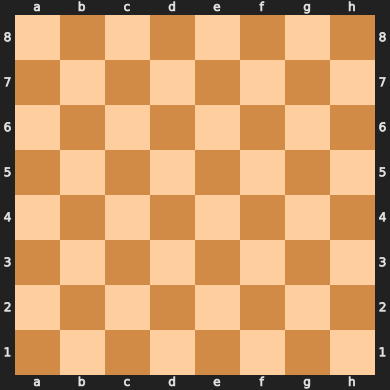

In [31]:
%matplotlib inline
board

In [32]:
intersection_points.shape, len(lines), lines.shape

((0,), 3, (3, 2))

In [43]:
dst = cv.Canny(img, 50, 200, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)


linesP.shape

(601, 1, 4)